# Regression: fitting data generated by a function

Let's start by loading required libraries.

In [1]:
# setting up parameters for plotting
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
fontsize_label = 12
fontsize_title = fontsize_label + 1
fontsize_legend = fontsize_label - 4


In [2]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import optax
from sklearn.metrics import mean_squared_error as mse
import numpy as np
from sklearn import preprocessing

We now generate data from the "unknown" target function.

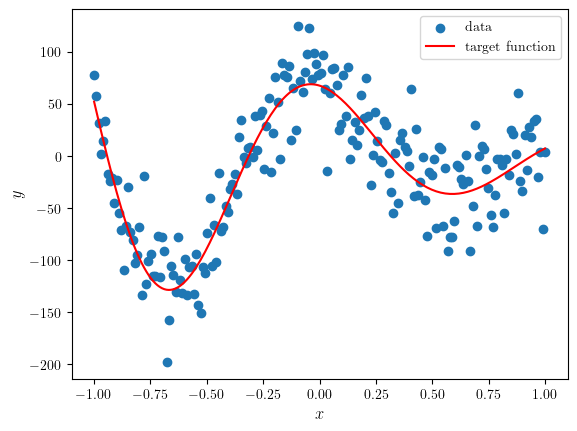

In [3]:
# function to approximate 
def f(x, noise=True):
    """
    Computes the function f(x) with optional noise.

    Parameters:
    -----------
    x : array_like
        Input array of shape (n_samples, n_features) containing the input data points.
        
    noise : bool, optional
        Flag indicating whether to add random noise to the function output.
        Default is True.

    Returns:
    --------
    y : ndarray
        Array of shape (n_samples,) containing the computed function values.
    """
    y = np.linalg.norm(x)**2*np.cos(5*jnp.prod(x, axis=1))*np.exp(-x[:,0])
    if noise:
        #replace with a polynomial maybe
        return y + 30*np.random.randn(x.shape[0],)
    else:
        return y 

# example in one dimension
x = jnp.linspace(-1,1,200).reshape(-1,1)
y = f(x)
# plot data 
fig, ax = plt.subplots()
ax.scatter(x, y, label="data")
ax.set_xlabel("$x$", fontsize=fontsize_label)
ax.set_ylabel("$y$", fontsize=fontsize_label)
ax.plot(x, f(x, noise=False), label="target function", color='r')
plt.legend()
plt.show()

In [4]:
class Regression(nn.Module):
    """
    Linear regression model implemented using JAX and Flax.

    This class defines a linear regression model with adjustable weights and bias. 
    The model predicts the output based on the input features by computing the dot 
    product of the input features and the weights, and adding the bias term.

    Attributes:
    -----------
    num_features : int
        Number of input features.

    Methods:
    --------
    setup()
        Initializes the weights and bias parameters of the linear regression model.

    __call__(x)
        Computes the output of the linear regression model for given input features x.
    """
    num_features: int

    def setup(self):
        self.w = self.param('weights', jax.nn.initializers.glorot_uniform(),
                                (self.num_features,1))
        self.shift = self.param('bias', jax.nn.initializers.glorot_uniform(),
                                (1,1))
    @nn.compact
    def __call__(self, x):
        out = jnp.sum(x*self.w[:,0], axis=1)
        return out + self.shift
# initializing the optimizer
learning_rate = 8e-1
optx = optax.adam(learning_rate=learning_rate)
# A function to generate polynomial features - equivalent to fitting using a polynomial 
def generate_poly(deg_poly, x):
    """
    Generate polynomial features for given input data.

    Parameters:
    -----------
    deg_poly : int
        Degree of the polynomial features to be generated.

    x : array-like of shape (n_samples, n_features)
        Input data. Each row represents a sample, and each column represents a feature.

    Returns:
    --------
    transformed_x : ndarray of shape (n_samples, n_poly_features)
        Transformed array containing the original features along with the polynomial features.

    """
    poly = PolynomialFeatures(deg_poly)
    return poly.fit_transform(x)


## Fitting using a affine mappings

In [5]:
# Split the dataset intro training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
# initialize the neural network 
model_linear = Regression(1)
params = model_linear.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    """
    Compute the mean squared error (MSE) between predicted and true values.

    Parameters:
    -----------
    params : ndarray
        Model parameters used for prediction.

    x : ndarray
        Input array of shape (batch_size, input_dim) containing the input data.

    y_true : ndarray
        True labels or target values corresponding to the input data.
    """
    y_pred = model_linear.apply(params, x)
    return jnp.sqrt(jnp.mean((y_pred-y_true)**2))

loss_fn = MSE # a function to evaluate the loss
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the loss and its gradient

# training loop
n_epochs = 2000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

epoch: 0, loss function: 69.14358520507812
epoch: 100, loss function: 63.33930587768555
epoch: 200, loss function: 63.3390998840332
epoch: 300, loss function: 63.3390998840332
epoch: 400, loss function: 63.3390998840332
epoch: 500, loss function: 63.3390998840332
epoch: 600, loss function: 63.3390998840332
epoch: 700, loss function: 63.3390998840332
epoch: 800, loss function: 63.3390998840332
epoch: 900, loss function: 63.3390998840332
epoch: 1000, loss function: 63.3390998840332
epoch: 1100, loss function: 63.3390998840332
epoch: 1200, loss function: 63.3390998840332
epoch: 1300, loss function: 63.3390998840332
epoch: 1400, loss function: 63.3390998840332
epoch: 1500, loss function: 63.3390998840332
epoch: 1600, loss function: 63.3390998840332
epoch: 1700, loss function: 63.3390998840332
epoch: 1800, loss function: 63.3390998840332
epoch: 1900, loss function: 63.3390998840332


Plot the learned function.

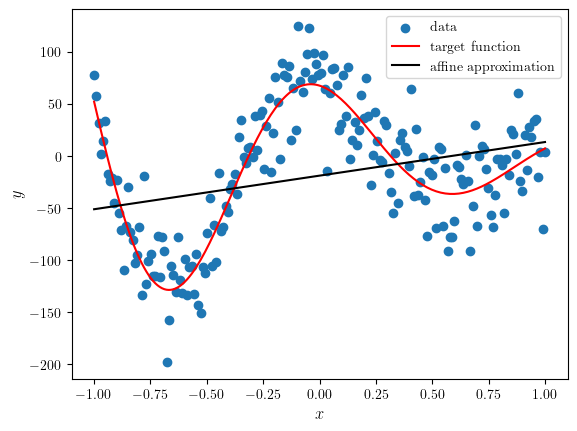

In [6]:
fig, ax = plt.subplots()
ax.scatter(x, y, label="data")
ax.set_xlabel("$x$", fontsize=fontsize_label)
ax.set_ylabel("$y$", fontsize=fontsize_label)
ax.plot(x, f(x, noise=False), label="target function", color='r')

params_linear = params
ypred = model_linear.apply(params_linear, x)
plt.plot(x, ypred.T, color='black', label="affine approximation")
plt.legend()
plt.show()

Evaluate the training and test errors. Is the affine approximation overfitting, underfitting or just correct?

## Fitting using polynomial regression

In [7]:
deg_poly = 20 #degree of the polynomial
# generate polynomial feature
x_poly = generate_poly(deg_poly, x)
# It is important to put the features on the same scale. Otherwise the learning algorithm would be biased
scaler = preprocessing.StandardScaler().fit(x_poly)
x_poly = scaler.transform(x_poly)

x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x_poly, y, test_size=0.33, random_state=42)

# initialize the neural network 
model_nonlinear = Regression(deg_poly + 1)
params = model_nonlinear.init(jax.random.PRNGKey(0), x_test_p)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    y_pred = model_nonlinear.apply(params, x)
    return jnp.sqrt(jnp.mean((y_pred-y_true)**2))

loss_fn = MSE
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 5000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train_p, y_train_p)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

epoch: 0, loss function: 69.03589630126953
epoch: 100, loss function: 39.65827560424805
epoch: 200, loss function: 36.07644271850586
epoch: 300, loss function: 33.7093505859375
epoch: 400, loss function: 32.075923919677734
epoch: 500, loss function: 31.148025512695312
epoch: 600, loss function: 30.665306091308594
epoch: 700, loss function: 30.41141700744629
epoch: 800, loss function: 30.24876594543457
epoch: 900, loss function: 30.132720947265625
epoch: 1000, loss function: 30.05228614807129
epoch: 1100, loss function: 29.962684631347656
epoch: 1200, loss function: 29.903409957885742
epoch: 1300, loss function: 29.846101760864258
epoch: 1400, loss function: 29.805662155151367
epoch: 1500, loss function: 29.763498306274414
epoch: 1600, loss function: 29.77313804626465
epoch: 1700, loss function: 29.70368194580078
epoch: 1800, loss function: 29.679405212402344
epoch: 1900, loss function: 29.65776252746582
epoch: 2000, loss function: 29.639488220214844
epoch: 2100, loss function: 29.62231

We now evaluate the training and test error. Does the model suffer from overfitting? from underfitting? from both?

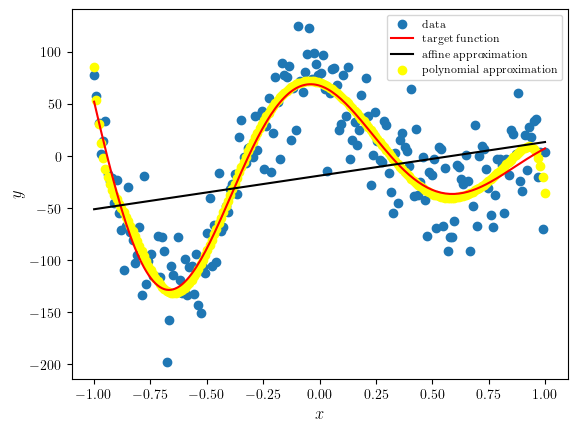

In [8]:
fig, ax = plt.subplots()
ax.scatter(x, y, label="data")
ax.set_xlabel("$x$", fontsize=fontsize_label)
ax.set_ylabel("$y$", fontsize=fontsize_label)
ax.plot(x, f(x, noise=False), label="target function", color='r')
ypred = model_linear.apply(params_linear, x)
plt.plot(x, ypred.T, color='black', label="affine approximation")
params_nonlinear = params
ypred = model_nonlinear.apply(params_nonlinear, x_poly)
plt.scatter(x, ypred.T, color='yellow', label="polynomial approximation")
plt.legend(fontsize=fontsize_legend)
plt.savefig("Regression.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Ponder

- The learning rate we use is quite large. Often, when training neural networks, one uses a learning rate of utmost $10^-3$. Why was a large learning rate in this example fine?
- How can you estimate whether you have an overfitting, underfitting, or just right scenario without visual help?
- Why did we split the overall data into training data and test data? 